Импортируем необходимые библиотеки и классы.

In [2]:
import pandas
from sklearn.tree import DecisionTreeClassifier

Загружаем данные из файла cardio.csv

In [3]:
data = pandas.read_csv('cardio.csv', index_col='id', sep=';')

Структура данных

In [4]:
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Переведем значения признака 'age' из дней в года. Посмотрим как изменилась структура данных

In [5]:
column = []
for a in data['age']:
    age = a//365
    column.append(age)
data['age'] = column
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


Т. к. признаки cholesterol (уровень холестерина) и gluc (уровень глюкозы в крови) - категориальные. Решающее дерево плохо работает с такими признаками, поскольку неизвестно, насколько сильно объекты из одной категории отличаются от объектов из других категорий - мы знаем только тот факт, что они различны, но не численные параметры. Построим по три бинарных признака, которые обозначат принадлежность человека к той или иной категории этих признаков. И посмотрим как выглядит датасет после преобразования

In [6]:
data = pandas.get_dummies(data=data, columns=['cholesterol', 'gluc'])
data.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,55,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0
2,51,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0
3,48,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,47,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0


Разобьем нашу выборку на тренировочную и отложенную. Целевая переменная хранится в колонке cardio.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns!='cardio'], data['cardio'])

# Деревья решений
Создаем объект решающего дерева с параметром random_state = 3(вариант) и максимальной глубиной построения дерева, равной 3, и обучите его на тестовых данных.

In [8]:
tree = DecisionTreeClassifier(random_state = 3, max_depth = 3)
tree.fit(X_train, y_train)
prediction = tree.predict(X_test)           
print(prediction) 

[1 0 1 ..., 0 1 1]


Код в следующей ячейке отрисовывает дерево.

Fetching package metadata ...........
Solving package specifications: .

UnsatisfiableError: The following specifications were found to be in conflict:
  - dbus
  - graphviz
  - pango
Use "conda info <package>" to see the dependencies for each package.

Fetching package metadata ...........
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /anaconda3:
#
pydotplus                 2.0.2                    py36_0  


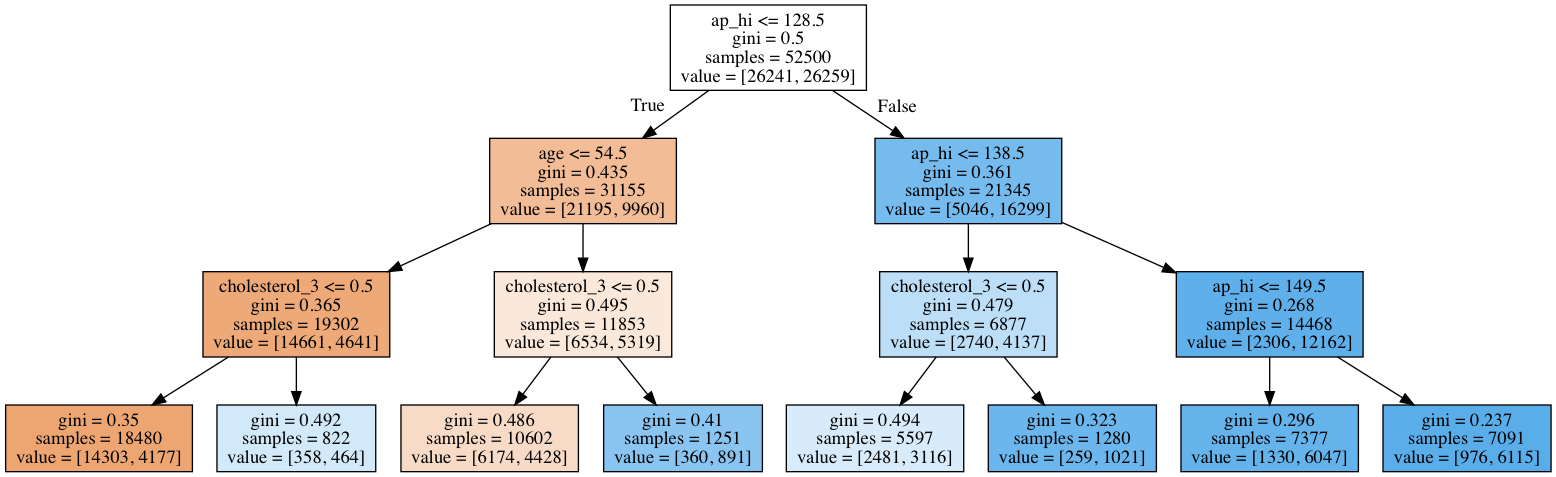

In [9]:
!conda install -y graphviz
!conda install -y pydotplus

import os
if os.name == 'nt':
    os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'
    
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

export_graphviz(tree, feature_names=X_train.columns, out_file='tree.dot', filled=True)
graph = pydotplus.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
Image(filename='tree.png')

**Какие признаки самые значимые в этой выборке?**
- верхнее артериальное давление
- возраст
- наличие высокого уровеня холестерина(3)

Перебором параметра max_depth получите максимальное значение score для нашей выборки.

In [10]:
depths = list(range(2, 12)) # список значений максимальной глубины
scores = []
i = 0
d = 0
for depth in depths:
    tree = DecisionTreeClassifier(max_depth = depth)
    tree.fit(X_train, y_train)
    prediction = tree.predict(X_test)           
    score = tree.score(X_test, y_test)
    scores.append(score)
    if score > i:
        i = score
        d = depth

# при какой глубине дерева получается максимальное значение score?
print('Глубина дерева, при максимальном значение score, равна', d)
# Чему равно максимальное score?
print('Максимальное значение score:', max(scores))

Глубина дерева, при максимальном значение score, равна 6
Максимальное значение score: 0.730857142857


График, отображающий зависимость score от max_depth:

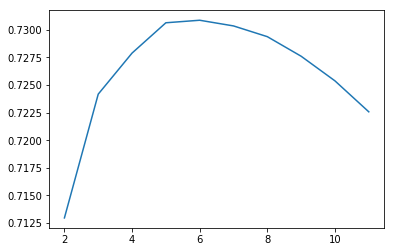

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(depths, scores)

# Случайный лес
Обучим на тех же данных случайный лес. Класс RandomForestClassifier находится в модуле sklearn.ensemble. Импортируем  и создаем новый объект леса. Параметр random_state равен 3, глубину построения деревьев равна 6 (наиболее оптимальная глубина из пункта про дерево)

In [12]:
from sklearn.ensemble import RandomForestClassifier

# создаем лес:
forest = RandomForestClassifier(max_depth=6, random_state=3)
forest.fit(X_train, y_train)                  # обучаем его
prediction = forest.predict(X_test)           # получим предсказания для тестовых данных

# насколько точными получились предсказания леса?
accuracy = forest.score(X_test, y_test)
print(accuracy)

0.727314285714


Подбераем наилучшие параметры для нашего леса. Будем варьировать n_estimators - это количество деревьев в лесу. Глубина построения - 6, random_state - 3.

In [13]:
estimators = list(range(1, 101)) # список значений количества деревьев
forest_scores = []
i = 0
d = 0
for n in estimators:
    forest = RandomForestClassifier(max_depth=6, random_state = 3, n_estimators = n)
    forest.fit(X_train, y_train)
    prediction = forest.predict(X_test)
    
    forest_score = forest.score(X_test, y_test)
    forest_scores.append(forest_score)
    if forest_score > i:
        i = forest_score
        d = n

# при каком количестве деревьев получается максимальное значение score?
print('Количество деревьев при максимальное значение score', d)
# Чему равно максимальное score? 
print('Максимальное score:', max(forest_scores))
#Результат получился лучше, чем у одиночного дерева?
best = 'Результат лучше' if max(forest_scores) > max(scores) else 'Результат хуже' 
print(best)

Количество деревьев при максимальное значение score 19
Максимальное score: 0.728742857143
Результат хуже


График зависимости качества работы нашего леса от количества деревьев.

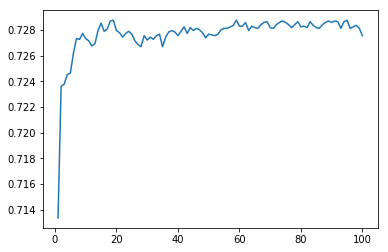

In [14]:
plt.plot(estimators, forest_scores)

# Метод ближайших соседей
Решим ту же задачу методом ближайших соседей. Используем KNeighborsClassifier из sklearn.neighbors. Основной параметр здесь - количество соседей (n_neighbors), поэтому нам нужно подобрать именно его.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = list(range(1, 10))
neighbors_scores = []
i=0
d=0
for n in n_neighbors:
    # обучаем, добавляем score в neighbors_score
    neighbors = KNeighborsClassifier(n_neighbors = n)
    neighbors.fit(X_train, y_train)
    prediction = neighbors.predict(X_test)
    
    score = neighbors.score(X_test, y_test)
    neighbors_scores.append(score)
    if score > i:
        i = score
        d = n
# При каком количестве соседей получается наилучший результат?
print('Количество соседей с лучшим результатом:', d)
print(max(neighbors_scores))

Количество соседей с лучшим результатом: 9
0.703828571429


График:

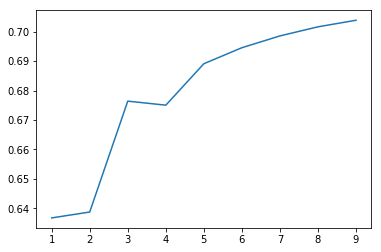

In [16]:
plt.plot(n_neighbors, neighbors_scores)

**Какой классификатор для данной задачи оказался лучше: дерево, лес или метод ближайших соседей?**

-ДЕРЕВО

# Кросс-валидация
Разобьем исходную выборку на матрицу признаков Х и вектор-столбец целевой переменной у.

In [18]:
X = data.loc[:, data.columns!='cardio']
y = data['cardio']

Создадим генератор разбиений, который разобьет нашу выборку на 4 части. Параметр random_state = 3. Снова будем подбирать оптимальное количество соседей. 

In [19]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=4, shuffle=True, random_state= 3) # создаем генератор разбиений

kfold_scores = []
i=0
d=0
# будем подбирать оптимальное количество соседей
for n in n_neighbors:
    
    # создать объект классификатора с n_neighbors=n
    kn_clf = KNeighborsClassifier(n_neighbors = n)
    kn_clf.fit(X_train, y_train)
    prediction = kn_clf.predict(X_test)
    score = kn_clf.score(X_test, y_test)
    
    current_score = cross_val_score(kn_clf, X, y, cv=kfold).mean() # берем средний score из всех подвыборок генератора разбиений
    #print(current_score)
    # добавить текущее значение score в список kfold_scores
    kfold_scores.append(current_score)
    if score > i:
        i = score
        d = n
# Какое количество соседей дает наибольшую точность? Какое значение точности получилось?
print('количество соседей с наимольшей точностью:', d, 'Значение точности:', i)
# Чему лучше верить: точности, посчитанной на отложенной выборке или полученной на кросс-валидации?
if i > current_score:
    print('точность, посчитанная на отложенной выборке лучше, чем на кросс-валидации')
else:
    print('точность, посчитанная на кросс-валидации лучше, чем на отложенной выборке')

количество соседей с наимольшей точностью: 9 Значение точности: 0.703828571429
точность, посчитанная на кросс-валидации лучше, чем на отложенной выборке


График:

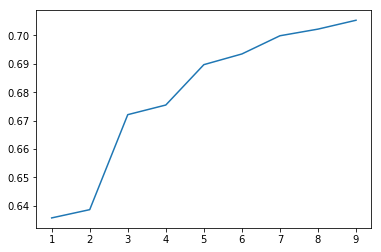

In [20]:
plt.plot(n_neighbors, kfold_scores)

Часто ненормированные признаки вносят искажения в модель, поскольку расстояние между двумя объектами по одному признаку может быть значительно больше, чем по другому. Попробуем метод ближайших соседей на нормированной выборке.

In [23]:
from sklearn.preprocessing import scale
X_scaled = scale(X) # нормируем

# Подберем оптимальное количество соседей
scaled_scores = []
i=0
d=0
for n in n_neighbors:
    
    # запишите тело цикла по аналогии с предыдущим пунктом
    kn_clf_new = KNeighborsClassifier(n_neighbors = n)
    kn_clf_new.fit(X_train, y_train)
    prediction = kn_clf_new.predict(X_test)
    score = kn_clf_new.score(X_test, y_test)
    
    current_score_new = cross_val_score(kn_clf_new, X_scaled, y, cv=kfold).mean() # берем средний score из всех подвыборок генератора разбиений
    #print(current_score_new)
    scaled_scores.append(current_score_new)
    if score > i:
        i = score
        d = n

print('Значение точности:', max(scaled_scores))

Значение точности: 0.660028571429


**Стоит ли нормировать признаки?**

-Из-за того, что многие алгоритмы машинного обучения чувствительны к масштабированию данных(к ним относятся метод ближайших соседей) количиственные признаки полезно нормализовать.

Посмотрим, какой классификатор лучше всего подходит к нашей задаче:

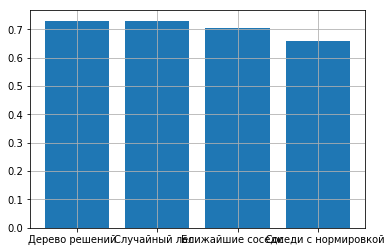

In [26]:
clfs = ['Дерево решений   ', 'Случайный лес  ', 'Ближайшие соседи   ', '     Соседи с нормировкой']
vals = [max(scores), max(forest_scores), max(kfold_scores), max(scaled_scores)]
inds = list(range(len(clfs)))

plt.bar(inds, vals)
plt.xticks(inds, clfs)
plt.grid()